## Intro to deep learning for medical imaging by [MD.ai](https://www.md.ai)

## Lesson 2. Lung X-Rays Semantic Segmentation

This lesson uses a MD.ai implemenation of [U-Net for Semantic Segmentation](https://arxiv.org/abs/1505.04597) of Lung X-Rays.

The MD.ai annotator is used to view the DICOM images, and to create the image level annotation. The MD.ai python client library is then used to download images and annotations, prepare the datasets, then are then used to train the model for classification. 

- MD.ai annotator project URL: https://public.md.ai/annotator/project/aGq4k6NW/workspace
- MD.ai python client libray URL: https://github.com/mdai/mdai-client-py
- MD.ai documentation URL: https://docs.md.ai/

The original public dataset is found [here](https://ceb.nlm.nih.gov/repositories/tuberculosis-chest-x-ray-image-data-sets/). This tutorial and use of this public dataset is for education purpose only. Note that any publications resulting from the use of this data must attribute the data to National Library of Medicine, National Institutes of Health, Bethesda, MD, USA, and cite this article: https://lhncbc.nlm.nih.gov/publication/pub9356  
For further information regarding the dataset, see [this faq](https://openi.nlm.nih.gov/faq.php).

**Intro to deep learning for medical imaging lessons**

- Lesson 1. Classification of chest vs. adominal X-rays using TensorFlow/Keras [Github](https://github.com/mdai/ml-lessons/blob/master/lesson1-xray-images-classification.ipynb) [Annotator](https://public.md.ai/annotator/project/PVq9raBJ)

- Lesson 2. Lung X-Rays Semantic Segmentation using UNets. [Github](https://github.com/mdai/ml-lessons/blob/master/lesson2-lung-xrays-segmentation.ipynb)
[Annotator](https://public.md.ai/annotator/project/aGq4k6NW/workspace) 

- Lesson 3. RSNA Pneumonia detection using Kaggle data format [Github](https://github.com/mdai/ml-lessons/blob/master/lesson3-rsna-pneumonia-detection-kaggle.ipynb) [Annotator](https://public.md.ai/annotator/project/LxR6zdR2/workspace) 
  
- Lesson 3. RSNA Pneumonia detection using MD.ai python client library [Github](https://github.com/mdai/ml-lessons/blob/master/lesson3-rsna-pneumonia-detection-mdai-client-lib.ipynb) [Annotator](https://public.md.ai/annotator/project/LxR6zdR2/workspace)

*Copyright 2018 MD.ai, Inc.   
Licensed under the Apache License, Version 2.0*

**Clink [here](https://colab.research.google.com/github/mdai/ml-lessons/blob/master/lesson2-lung-xrays-segmentation.ipynb) to launch this notebook on Google Colab.**
For GPU, go to Runtime -> Change runtime type -> switch to Python 3, and turn on GPU.

In [1]:
# install dependencies not included by Colab
# use pip3 to ensure compatibility w/ Google Deep Learning Images 
!pip3 install -q pydicom 
!pip3 install -q tqdm 
!pip3 install -q imgaug 

### Import the `mdai` library

On Colab, run the block below to install the `mdai` client library into your python environment.

In [2]:
!pip3 install --upgrade -q mdai

In [3]:
import os
import sys
import random
import math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import json
import pydicom
from imgaug import augmenters as iaa

import skimage.io
import skimage.measure
from tqdm import tqdm
from PIL import Image

import requests
import shutil
import zipfile

In [ ]:
import mdai
mdai.__version__

### Create an `mdai` client

The mdai client requires an access token, which authenticates you as the user. To create a new token or select an existing token, navigate to the "Personal Access Tokens" tab on your user settings page at the specified MD.ai domain (e.g., public.md.ai).

**Important: keep your access tokens safe. Do not ever share your tokens.**

In [5]:
mdai_client = mdai.Client(domain='public.md.ai', access_token="")

Successfully authenticated to public.md.ai.


### Define project

Define a project you have access to by passing in the project id. The project id can be found in the URL in the following format: `https://public.md.ai/annotator/project/{project_id}`.

For example, `project_id` would be `XXXX` for `https://public.md.ai/annotator/project/XXXX`.

Specify optional `path` as the data directory (if left blank, will default to current working directory).

In [6]:
p = mdai_client.project('aGq4k6NW', path='./lesson2-data')

Using path './lesson2-data' for data.
Preparing annotations export for project aGq4k6NW...                                                
Preparing images export for project aGq4k6NW...                                                     
Using cached images data for project aGq4k6NW.
Using cached annotations data for project aGq4k6NW.


In [7]:
# download MD.ai's dilated unet implementation 
UNET_URL = 'https://s3.amazonaws.com/md.ai-ml-lessons/unet.zip'
UNET_ZIPPED = 'unet.zip'

if not os.path.exists(UNET_ZIPPED): 
    r = requests.get(UNET_URL, stream=True)
    if r.status_code == requests.codes.ok:
        with open(UNET_ZIPPED, "wb") as f:
            shutil.copyfileobj(r.raw, f)
    else:
        r.raise_for_status()

    with zipfile.ZipFile(UNET_ZIPPED) as zf:
        zf.extractall()

### Set label ids

Selected label ids must be explicitly set by `Project#set_label_ids` method in order to prepare datasets.

In [8]:
p.show_label_groups()

Label Group, Id: G_Vdj4o2, Name: Default group
	Labels:
	Id: L_A8Jm3d, Name: Lung



In [9]:
# this maps label ids to class ids as a dict obj
labels_dict = {'L_A8Jm3d':1 # Lung   
              }

print(labels_dict)
p.set_labels_dict(labels_dict)

{'L_A8Jm3d': 1}
freeform


### Create the *Training* and *Validation* datasets

In [10]:
p.show_datasets() 

Datasets:
Id: D_rQLwzo, Name: Dataset



In [11]:
dataset = p.get_dataset_by_id('D_rQLwzo')
dataset.prepare()

In [12]:
image_ids = dataset.get_image_ids()
len(image_ids)

138

### Display a few images

Input image pixel range exceeds 255, rescaling for visualization.
Input image pixel range exceeds 255, rescaling for visualization.
Input image pixel range exceeds 255, rescaling for visualization.


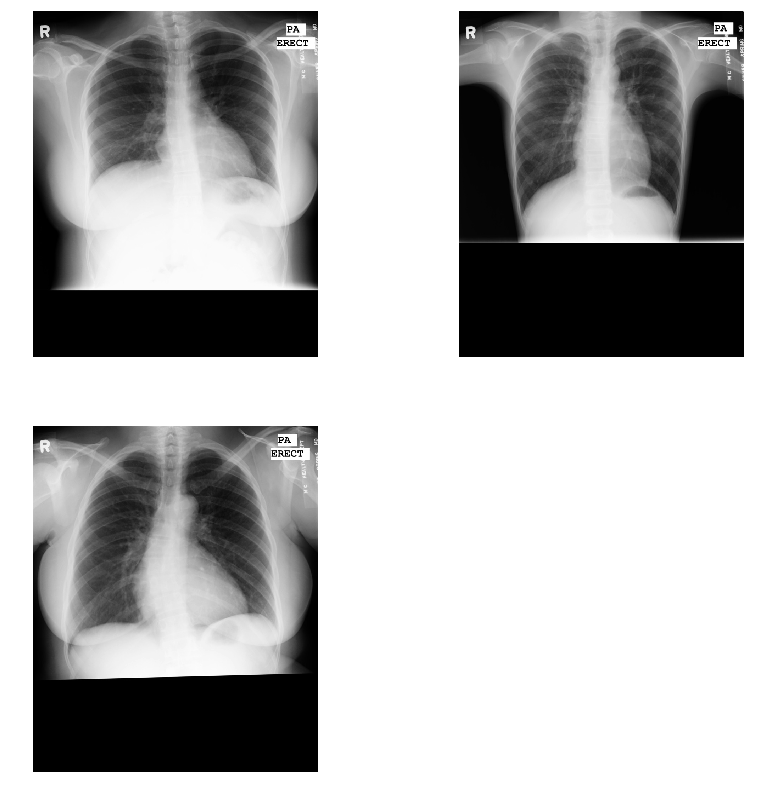

In [13]:
# visualize a few train images 
mdai.visualize.display_images(image_ids[:3], cols=2)

In [14]:
imgs_anns_dict = dataset.imgs_anns_dict

In [ ]:
from unet import dataset
from unet import dilated_unet
from unet import train

In [16]:
images, masks = dataset.load_images(imgs_anns_dict)

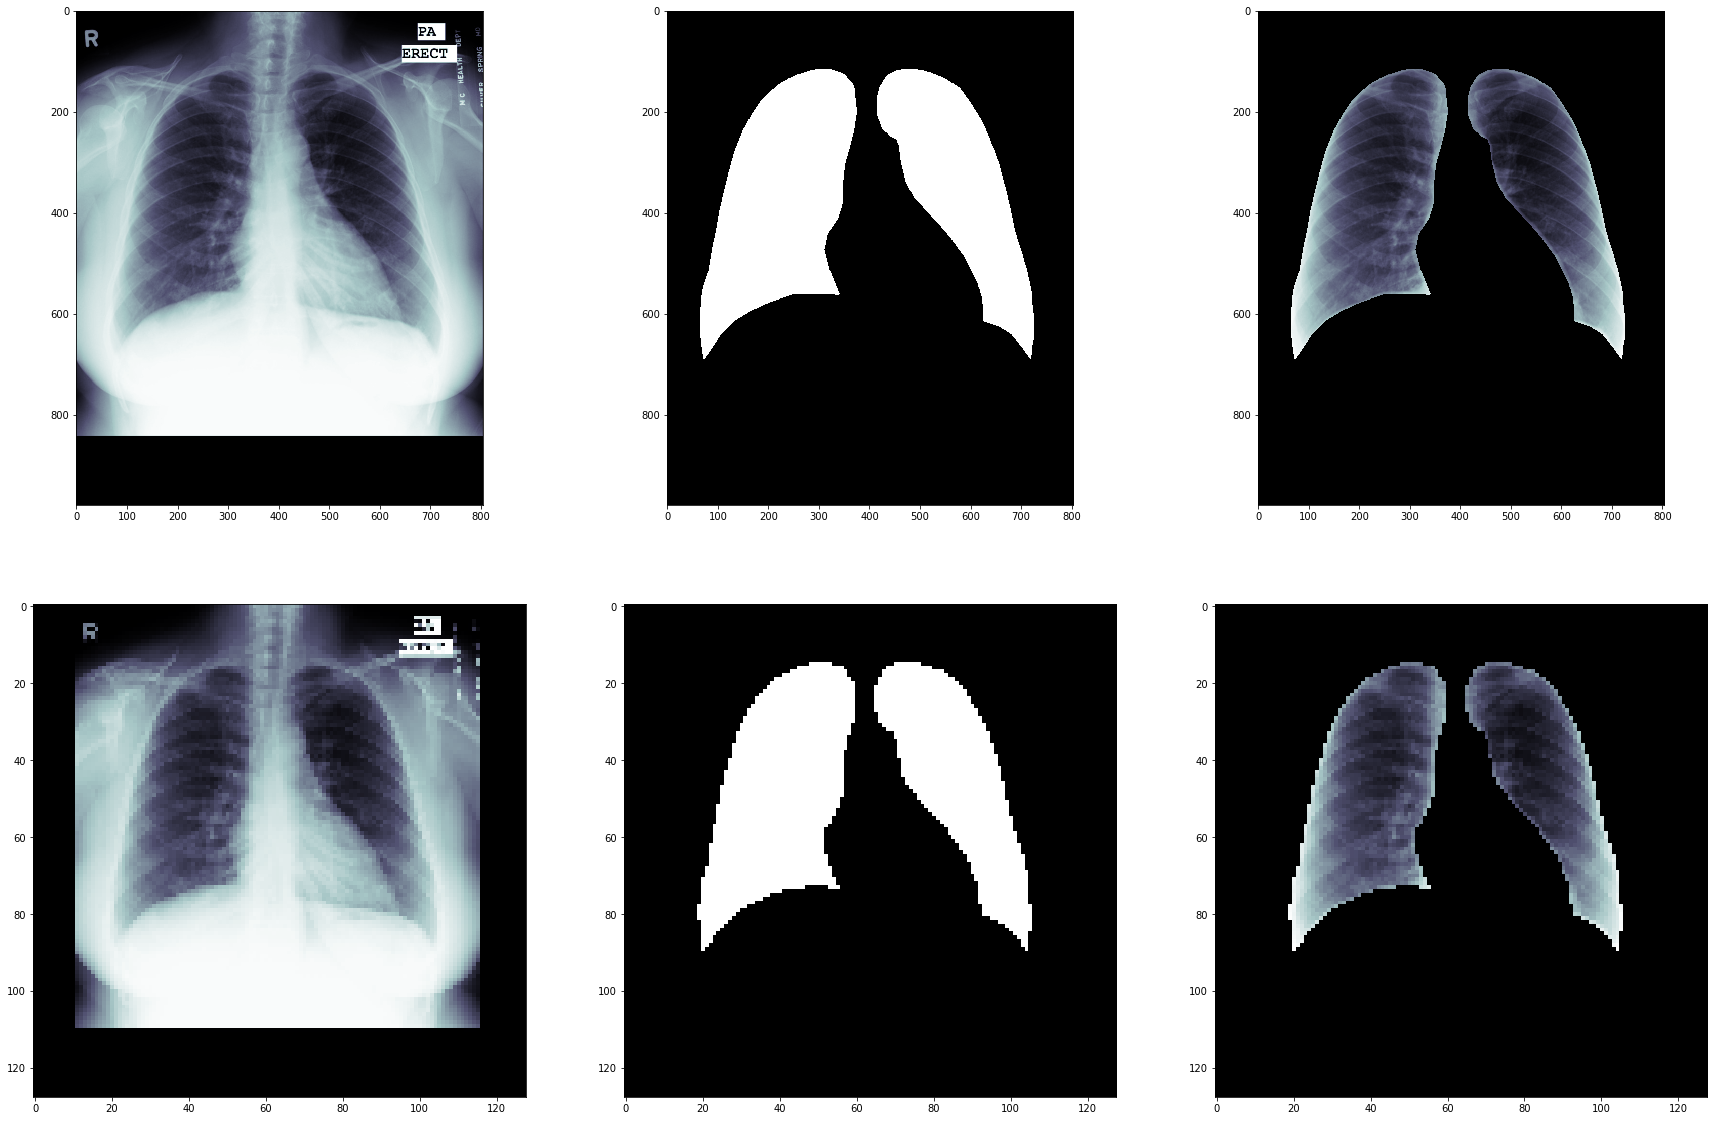

In [17]:
img_index = random.choice(range(len(imgs_anns_dict)))
img_fps = list(imgs_anns_dict.keys())
img_fp = img_fps[img_index]
img = mdai.visualize.load_dicom_image(img_fp)
ann = imgs_anns_dict[img_fp]
img_width = img.shape[1]
img_height = img.shape[0]

mask = np.zeros((img_height, img_width), dtype=np.uint8) 
for a in ann:     
    vertices = np.array(a['data']['vertices'])
    vertices = vertices.reshape((-1,2))                     
    cv2.fillPoly(mask, np.int32([vertices]), (255,255,255))
    
plt.figure(figsize=(30, 20))
plt.subplot(2,3,1)
plt.imshow(img, cmap=plt.cm.bone)
plt.axis('off')

plt.subplot(2,3,2)
plt.imshow(mask, cmap=plt.cm.bone)
plt.axis('off')

plt.subplot(2,3,3)              
plt.imshow(cv2.bitwise_and(img, img, mask=mask.astype(np.uint8)), cmap=plt.cm.bone)
plt.axis('off')

plt.subplot(2,3,4)
plt.imshow(images[img_index,:,:,0], cmap=plt.cm.bone)
plt.axis('off')

plt.subplot(2,3,5)
plt.imshow(masks[img_index,:,:,0], cmap=plt.cm.bone)
plt.axis('off')

plt.subplot(2,3,6)
plt.imshow(cv2.bitwise_and(images[img_index,:,:,0], images[img_index,:,:,0], 
                           mask=masks[img_index,:,:,0].astype(np.uint8)), cmap=plt.cm.bone)
plt.axis('off')

In [18]:
import tensorflow as tf 
config = tf.ConfigProto()
config.gpu_options.allow_growth = True

In [19]:
CONFIG_FP = 'unet/configs/11.json'
name = os.path.basename(CONFIG_FP).split('.')[0]
print(name)

11


In [20]:
with open(CONFIG_FP, 'r') as f:
    config = json.load(f)

In [21]:
history = train.train(config, name, images,masks)

Epoch 1/20
 - 11s - loss: 0.5175 - acc: 0.7686 - dice: 0.0316 - iou: 0.0415 - val_loss: 0.4416 - val_acc: 0.7909 - val_dice: 3.0340e-04 - val_iou: 1.5172e-04

Epoch 00001: val_loss improved from inf to 0.44165, saving model to /home/txia/mdai-git/ml-lessons/unet/trained/model_11.hdf5
Epoch 2/20
 - 10s - loss: 0.3911 - acc: 0.8051 - dice: 3.5012e-04 - iou: 1.7509e-04 - val_loss: 0.4153 - val_acc: 0.7909 - val_dice: 3.0340e-04 - val_iou: 1.5172e-04

Epoch 00002: val_loss improved from 0.44165 to 0.41534, saving model to /home/txia/mdai-git/ml-lessons/unet/trained/model_11.hdf5
Epoch 3/20
 - 10s - loss: 0.3535 - acc: 0.8143 - dice: 0.0863 - iou: 0.0374 - val_loss: 0.3731 - val_acc: 0.8099 - val_dice: 0.2037 - val_iou: 0.0670

Epoch 00003: val_loss improved from 0.41534 to 0.37307, saving model to /home/txia/mdai-git/ml-lessons/unet/trained/model_11.hdf5
Epoch 4/20
 - 10s - loss: 0.2887 - acc: 0.8689 - dice: 0.5541 - iou: 0.3779 - val_loss: 0.3027 - val_acc: 0.9031 - val_dice: 0.7510 - val

dict_keys(['val_loss', 'val_acc', 'val_dice', 'val_iou', 'loss', 'acc', 'dice', 'iou'])


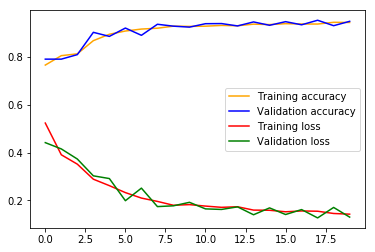

In [22]:
import matplotlib.pyplot as plt

print(history.history.keys())

plt.figure()
plt.plot(history.history['acc'], 'orange', label='Training accuracy')
plt.plot(history.history['val_acc'], 'blue', label='Validation accuracy')
plt.plot(history.history['loss'], 'red', label='Training loss')
plt.plot(history.history['val_loss'], 'green', label='Validation loss')
plt.legend()
plt.show()

In [23]:
from keras.models import load_model
import keras.backend as K

model_name = 'unet/trained/model_'+name+'.hdf5'
print(model_name)
model = load_model(model_name, custom_objects={'dice': train.dice, 'iou': train.iou})

unet/trained/model_11.hdf5


100


Text(0.5,1,'Predicted Lung Segmentation')

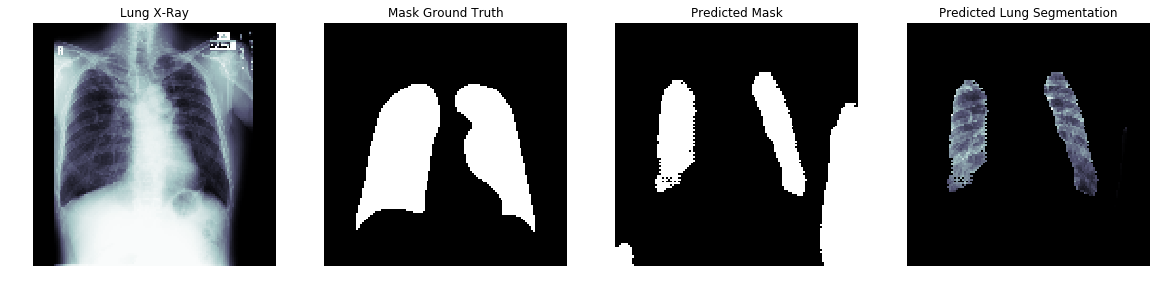

In [28]:
plt.figure(figsize=(20, 10))

img_index = random.choice(range(images.shape[0]))

print(img_index)
plt.subplot(1,4,1)
random_img = images[img_index,:,:,0]
plt.imshow(random_img, cmap=plt.cm.bone)
plt.axis('off')
plt.title('Lung X-Ray')

plt.subplot(1,4,2)
random_mask = masks[img_index,:,:,0]
plt.imshow(random_mask, cmap=plt.cm.bone)
plt.axis('off')
plt.title('Mask Ground Truth')

random_img_2 = np.expand_dims(np.expand_dims(random_img, axis=0), axis=3)
mask = model.predict(random_img_2)[0][:,:,0] > 0.5
plt.subplot(1,4,3)
plt.imshow(mask, cmap=plt.cm.bone)
plt.axis('off')
plt.title('Predicted Mask')

plt.subplot(1,4,4)
plt.imshow(cv2.bitwise_and(random_img, random_img, mask=mask.astype(np.uint8)), cmap=plt.cm.bone)
plt.axis('off')
plt.title('Predicted Lung Segmentation')